# Fine-tuning CNN

## 1. Dataset

In [1]:
import os
import numpy as np
np.random.seed(777)
import cv2
import scipy
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
path_to_caffemodel = 'bvlc_reference_caffenet.caffemodel'
path_to_chainermodel = 'bvlc_reference_caffenet.chainermodel'
path_to_mean = 'ilsvrc_2012_mean.npy'
path_to_dataset = 'oxfordflower17/'

In [3]:
if not os.path.isdir(path_to_dataset):
    ! wget http://www.robots.ox.ac.uk/~vgg/data/bicos/data/oxfordflower17.tar
    ! tar -xf oxfordflower17.tar

In [4]:
from scipy import io
labels = scipy.io.loadmat(path_to_dataset + 'imagelabels.mat')['labels'][0]
labels -= 1
print(labels)
print(len(labels))

[ 0  0  0 ..., 16 16 16]
1360


In [5]:
path_to_images = path_to_dataset + 'jpg/'
images = os.listdir(path_to_images)
images = [path_to_images+i for i in images if i.endswith('.jpg')]
images.sort()
print(len(images))

1360


In [6]:
train_data = []
train_labels = []
test_data = []
test_labels = []

for i,image in enumerate(images):
    if i % 80 == 0: 
        perm = np.random.permutation(80)
    if perm[i % 80] < 60:
        train_data.append(images[i])
        train_labels.append(labels[i])
    else:
        test_data.append(images[i])
        test_labels.append(labels[i])

In [7]:
label_names = ['Daffodil', 'Snowdrop', 'Lily Valley', 'Bluebell',
               'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
               'Sunflower', 'Daisy', 'Colls\' Foot', 'Dandelion',
               'Cowslip', 'Buttercup', 'Windflower', 'Pansy']

Daffodil


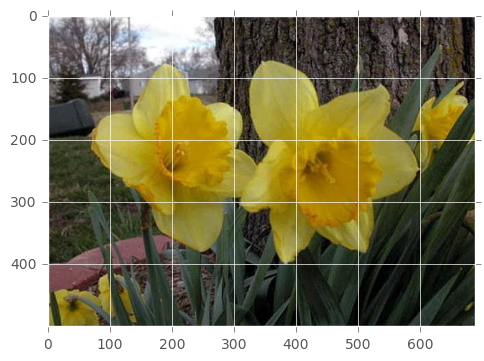

In [8]:
plt.imshow(cv2.imread(train_data[0], cv2.IMREAD_COLOR)[:,:,[2,1,0]])
print(label_names[train_labels[0]])

## 2. Model

In [9]:
if not os.path.isfile(path_to_caffemodel):
    ! wget http://dl.caffe.berkeleyvision.org/bvlc_reference_caffenet.caffemodel

In [10]:
import chainer
from chainer import cuda
import chainer.functions as F
import chainer.links as L
from chainer import optimizers
from chainer import serializers

In [11]:
import chainer.functions.caffe
if not os.path.isfile(path_to_chainermodel):
    caffenet = chainer.functions.caffe.CaffeFunction(path_to_model)
    chainer.serializers.save_hdf5(path_to_chainermodel, caffenet)
else:
    from caffenet import CaffeNet
    caffenet = CaffeNet()
    chainer.serializers.load_hdf5(path_to_chainermodel, caffenet)

In [12]:
class Finetune(chainer.Chain):

    def __init__(self):
        super(self.__class__, self).__init__(
            conv1=L.Convolution2D(3, 96, ksize=11, stride=4),
            conv2=L.Convolution2D(96, 256, ksize=5, pad=2),
            conv3=L.Convolution2D(256, 384, ksize=3, pad=1),
            conv4=L.Convolution2D(384, 384, ksize=3, pad=1),
            conv5=L.Convolution2D(384, 256, ksize=3, pad=1),
        )
        self.ft1 = chainer.Chain(
            fc6=L.Linear(9216, 4096),
            fc7=L.Linear(4096, 4096),
        )
        self.ft2 = chainer.Chain(
            fc8ft=L.Linear(4096, 17),
        )

    def __call__(self, x, t, train=True):
        y = self.forward(x, train=train)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

    def forward(self, x, train=False):
        if train: x.volatile = 'on' # do not backward while volatile='on'
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        h = F.local_response_normalization(h, k=5, n=5, alpha=1e-4, beta=0.75)
        h *= np.power(5, 0.75)
        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        h = F.local_response_normalization(h, k=5, n=5, alpha=1e-4, beta=0.75)
        h *= np.power(5, 0.75)
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.conv5(h))
        h = F.max_pooling_2d(h, ksize=3, stride=2)
        if train: h.volatile = 'off' # backward to fc6
        h = F.dropout(F.relu(self.ft1.fc6(h)), train=train)
        h = F.dropout(F.relu(self.ft1.fc7(h)), train=train)
        h = self.ft2.fc8ft(h)
        return h

In [13]:
def load_params(dst_model, src_model):
    for src_param in src_model.children():
        for dst_param in dst_model.children():
            if dst_param.name == src_param.name:
                try:
                    dst_param.copyparams(src_param)
                except Exception as e:
                    print(e)
                continue

In [14]:
model = Finetune()
load_params(model, caffenet)
load_params(model.ft1, caffenet)
del caffenet

## 3. Image Preprocessing

In [15]:
if not os.path.isfile(path_to_mean):
    ! wget https://github.com/BVLC/caffe/raw/master/python/caffe/imagenet/ilsvrc_2012_mean.npy

In [16]:
mean = np.load(path_to_mean).mean(1).mean(1)
print(mean) # BGR order

[ 104.00698793  116.66876762  122.67891434]


In [17]:
def improcess(image, train):
    if train:
        image = cv2.resize(image, (256,256))
        if np.random.randint(0, 1): 
            image = image[:,::-1,:] # flip
        t = np.random.randint(0, 256-1-227) # top
        l = np.random.randint(0, 256-1-227) # left
        image = image[t:t+227, l:l+227, :] # crop
    else:
        image = cv2.resize(image, (227,227))
    image = np.transpose(image, (2,0,1)).astype(np.float32)
    image -= mean[:, np.newaxis, np.newaxis]
    return image

def imdeprocess(image):
    image += mean[:, np.newaxis, np.newaxis]
    image /= 255
    image = image.transpose(1,2,0)
    return image

## 4. Training

In [18]:
optimizer1 = chainer.optimizers.MomentumSGD(lr=1e-5)
optimizer1.setup(model.ft1)
optimizer1.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))

optimizer2 = chainer.optimizers.MomentumSGD(lr=1e-3)
optimizer2.setup(model.ft2)
optimizer2.add_hook(chainer.optimizer.WeightDecay(rate=0.0005))

In [19]:
gpuid = 0 # gpu device ID (cpu if negative)
xp = cuda.cupy if gpuid >= 0 else np

if gpuid >= 0:
    cuda.get_device(gpuid).use()
    model.to_gpu()
    model.ft1.to_gpu()
    model.ft2.to_gpu()

In [20]:
import csv

log_train = open('ft_train.log', 'w')
writer_train = csv.writer(log_train, lineterminator='\n')
writer_train.writerow(('iter', 'loss'))

log_test = open('ft_test.log', 'w')
writer_test = csv.writer(log_test, lineterminator='\n')
writer_test.writerow(('iter', 'loss', 'acc'))

14

In [21]:
def create_batch(x, t, indices, train):
    n_batch = len(indices)
    im_size = 227
    x_batch = np.zeros((n_batch,3,im_size,im_size), dtype=np.float32)
    t_batch = np.zeros(n_batch, dtype=np.int32)
    for i, index in enumerate(indices):
        t_batch[i] = t[index]
        image = cv2.imread(x[index], cv2.IMREAD_COLOR)
        x_batch[i] = improcess(image, train)
    return x_batch, t_batch

In [22]:
import sys
from tqdm import tqdm

def test(x, t):
    batchsize = 20
    sum_accuracy = sum_loss = 0
    with tqdm(total=len(t)) as pbar:
        pbar.set_description('test')
        for i in range(0, len(t), batchsize):
            pbar.update(batchsize)
            x_batch, t_batch = create_batch(x, t, np.arange(i,i + batchsize), train=False)
            x_batch = chainer.Variable(xp.asarray(x_batch), volatile='on')
            t_batch = chainer.Variable(xp.asarray(t_batch), volatile='on')
            loss = model(x_batch, t_batch, train=False)
            sum_loss += float(loss.data)
            sum_accuracy += float(model.accuracy.data)
    sys.stderr.flush()
    return sum_loss * batchsize / len(t), sum_accuracy * batchsize / len(t)

In [23]:
loss, acc = test(test_data, test_labels)
writer_test.writerow((0, loss, acc))
sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}'.format(loss, acc))

test: 100%|██████████| 340/340 [00:02<00:00, 173.96it/s]


test: loss=3.743332, accuracy=0.058824

In [24]:
n_epoch = 30
batchsize = 20
n_data = len(train_labels)
x = train_data
t = train_labels

# Learning loop
for epoch in range(n_epoch):
    sys.stdout.write('(epoch: {})\n'.format(epoch + 1))
    sys.stdout.flush()
    
    # training
    perm = np.random.permutation(n_data)
    with tqdm(total=n_data) as pbar:
        for i in range(0, n_data, batchsize):
            it = epoch * n_data + i + batchsize
            x_batch, t_batch = create_batch(x, t, perm[i:i + batchsize], train=True)
            x_batch = chainer.Variable(xp.asarray(x_batch), volatile='off')
            t_batch = chainer.Variable(xp.asarray(t_batch), volatile='off')
            model.ft1.cleargrads()
            model.ft2.cleargrads()
            loss = model(x_batch, t_batch)
            loss.backward()
            optimizer1.update()
            optimizer2.update()
            loss = float(model.loss.data)
            writer_train.writerow((it, loss))
            pbar.set_description('train: loss={0:.6f}'.format(loss))
            pbar.update(batchsize)
    sys.stderr.flush()
    
    # evaluate
    loss, acc = test(test_data, test_labels)
    writer_test.writerow((it, loss, acc))
    sys.stdout.write('test: loss={0:.6f}, accuracy={1:.6f}\n'.format(loss, acc))

(epoch: 1)


test: 100%|██████████| 340/340 [00:01<00:00, 176.02it/s]


test: loss=0.510752, accuracy=0.850000
(epoch: 2)


test: 100%|██████████| 340/340 [00:01<00:00, 176.45it/s]


test: loss=0.405886, accuracy=0.882353
(epoch: 3)


test: 100%|██████████| 340/340 [00:01<00:00, 177.15it/s]


test: loss=0.426957, accuracy=0.882353
(epoch: 4)


test: 100%|██████████| 340/340 [00:01<00:00, 176.17it/s]


test: loss=0.390546, accuracy=0.888235
(epoch: 5)


test: 100%|██████████| 340/340 [00:01<00:00, 176.71it/s]


test: loss=0.397735, accuracy=0.902941
(epoch: 6)


test: 100%|██████████| 340/340 [00:01<00:00, 176.19it/s]


test: loss=0.466770, accuracy=0.885294
(epoch: 7)


test: 100%|██████████| 340/340 [00:01<00:00, 174.06it/s]


test: loss=0.425488, accuracy=0.900000
(epoch: 8)


test: 100%|██████████| 340/340 [00:01<00:00, 176.82it/s]


test: loss=0.394764, accuracy=0.900000
(epoch: 9)


test: 100%|██████████| 340/340 [00:01<00:00, 176.36it/s]


test: loss=0.404655, accuracy=0.891176
(epoch: 10)


test: 100%|██████████| 340/340 [00:01<00:00, 176.38it/s]


test: loss=0.397816, accuracy=0.900000
(epoch: 11)


test: 100%|██████████| 340/340 [00:01<00:00, 176.43it/s]


test: loss=0.414375, accuracy=0.905882
(epoch: 12)


test: 100%|██████████| 340/340 [00:01<00:00, 178.11it/s]


test: loss=0.343030, accuracy=0.908824
(epoch: 13)


test: 100%|██████████| 340/340 [00:01<00:00, 178.16it/s]


test: loss=0.416319, accuracy=0.897059
(epoch: 14)


test: 100%|██████████| 340/340 [00:01<00:00, 178.20it/s]


test: loss=0.368548, accuracy=0.900000
(epoch: 15)


test: 100%|██████████| 340/340 [00:01<00:00, 178.25it/s]


test: loss=0.379767, accuracy=0.905882
(epoch: 16)


test: 100%|██████████| 340/340 [00:01<00:00, 178.08it/s]


test: loss=0.329294, accuracy=0.905882
(epoch: 17)


test: 100%|██████████| 340/340 [00:01<00:00, 177.99it/s]


test: loss=0.422517, accuracy=0.900000
(epoch: 18)


test: 100%|██████████| 340/340 [00:01<00:00, 177.97it/s]


test: loss=0.364240, accuracy=0.914706
(epoch: 19)


test: 100%|██████████| 340/340 [00:01<00:00, 177.98it/s]


test: loss=0.374264, accuracy=0.908824
(epoch: 20)


test: 100%|██████████| 340/340 [00:01<00:00, 176.54it/s]


test: loss=0.354858, accuracy=0.902941
(epoch: 21)


test: 100%|██████████| 340/340 [00:01<00:00, 173.03it/s]


test: loss=0.358450, accuracy=0.911765
(epoch: 22)


test: 100%|██████████| 340/340 [00:01<00:00, 176.54it/s]


test: loss=0.364325, accuracy=0.905882
(epoch: 23)


test: 100%|██████████| 340/340 [00:01<00:00, 177.21it/s]


test: loss=0.356257, accuracy=0.900000
(epoch: 24)


test: 100%|██████████| 340/340 [00:01<00:00, 176.08it/s]


test: loss=0.387180, accuracy=0.905882
(epoch: 25)


test: 100%|██████████| 340/340 [00:01<00:00, 176.38it/s]


test: loss=0.382012, accuracy=0.902941
(epoch: 26)


test: 100%|██████████| 340/340 [00:01<00:00, 176.71it/s]


test: loss=0.391696, accuracy=0.908824
(epoch: 27)


test: 100%|██████████| 340/340 [00:01<00:00, 175.93it/s]


test: loss=0.352585, accuracy=0.908824
(epoch: 28)


test: 100%|██████████| 340/340 [00:01<00:00, 172.02it/s]


test: loss=0.394447, accuracy=0.908824
(epoch: 29)


test: 100%|██████████| 340/340 [00:01<00:00, 171.06it/s]


test: loss=0.354203, accuracy=0.914706
(epoch: 30)


test: 100%|██████████| 340/340 [00:01<00:00, 171.52it/s]


test: loss=0.386033, accuracy=0.902941


In [25]:
log_train.close()
log_test.close()
log_train = np.loadtxt('ft_train.log', delimiter=',', skiprows=True).transpose()
log_test = np.loadtxt('ft_test.log', delimiter=',', skiprows=True).transpose()

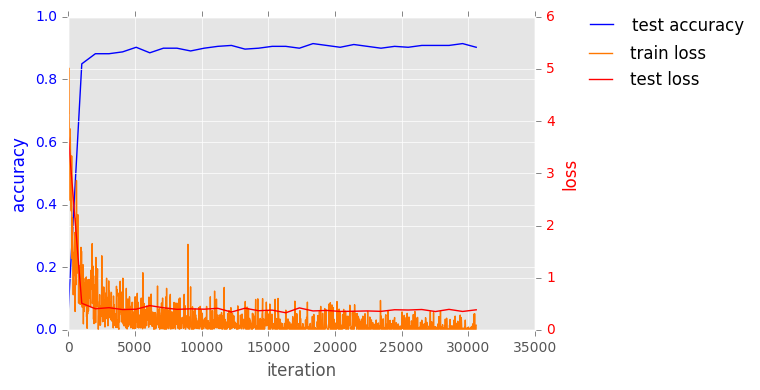

In [26]:
fig, ax1 = plt.subplots()
ax1.plot(log_test[0], log_test[2], 'b-')
ax1.set_xlabel('iteration')
ax1.set_ylabel('accuracy', color='b')
ax1.set_ylim(0, 1)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
plt.legend(['test accuracy'], bbox_to_anchor=(1.48, 1.05), framealpha=0)
ax2 = ax1.twinx()
ax2.plot(log_train[0], log_train[1], color='#ff7700')
ax2.plot(log_test[0], log_test[1], 'r-')
ax2.set_ylabel('loss', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.legend(['train loss', 'test loss'], bbox_to_anchor=(1.4, 0.96), framealpha=0)
plt.tight_layout()
plt.show()

## 5. Inference

Colls' Foot


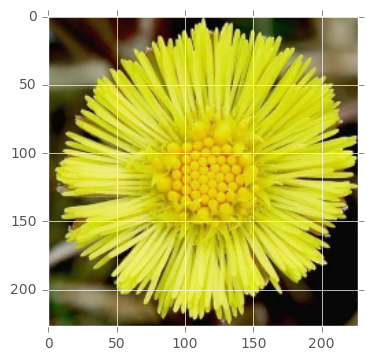

In [27]:
index = np.random.randint(len(test_data))
image = cv2.imread(test_data[index], cv2.IMREAD_COLOR)
x = improcess(image, train=False)
plt.imshow(imdeprocess(improcess(image, train=False))[:,:,::-1])
print(label_names[test_labels[index]])

In [28]:
def predict(x, top=5):
    x = x[np.newaxis,:,:,:]
    x_batch = chainer.Variable(xp.asarray(x), volatile='on')
    y_batch = F.softmax(model.forward(x_batch))
    results = list(zip(y_batch.data[0], label_names))
    results.sort(reverse=True)
    for rank, (score, name) in enumerate(results[:top], start=1):
        print('#{0:2d}| {1:12s} | {2:7.3f}%'.format(rank, name, float(score*100)))

In [29]:
predict(x)

# 1| Colls' Foot  |  99.998%
# 2| Daisy        |   0.002%
# 3| Sunflower    |   0.000%
# 4| Dandelion    |   0.000%
# 5| Buttercup    |   0.000%
